In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import pathlib
import re
import json
import math
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import statsmodels.api as sm
from functools import partial

%load_ext autoreload
%autoreload 1
from utils.hourly_volas_and_dt import hourly_volas_and_dt
%aimport utils.hourly_volas_and_dt

from utils.rolling import rolling
%aimport utils.rolling

from utils.train_test_split import train_test_split
%aimport utils.train_test_split

from utils.loss_functions import mean_squared, quasi_likelihood
%aimport utils.loss_functions

from utils.r_squared_daily import r_squared_daily
%aimport utils.r_squared_daily

from utils.mean_squared_daily import mean_squared_daily
%aimport utils.mean_squared_daily

from utils.q_likelihood_daily import q_likelihood_daily
%aimport utils.q_likelihood_daily

from itertools import product

from utils.mean_squared_oos import mean_squared_oos
%aimport utils.mean_squared_oos
from utils.q_likelihood_oos import q_likelihood_oos
%aimport utils.q_likelihood_oos
from utils.r_squared_oos import r_squared_oos
%aimport utils.r_squared_oos
from utils.q_likelihood_oos_details import q_likelihood_oos_details
%aimport utils.q_likelihood_oos_details
from utils.squared_errors_oos import squared_errors_oos
%aimport utils.squared_errors_oos

import import_ipynb

from rolling_data_AR import in_sample_AR, in_sample_HAR, in_sample_HAR_plus_I

from statsmodels.regression.rolling import RollingOLS

importing Jupyter notebook from rolling_data_AR.ipynb
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
from utils.diebold_mariano_test import diebold_mariano_variance_estimate, normalised_stat, normal_p_value, autocovariance
%aimport utils.diebold_mariano_test

In [2]:
symbols_list_file_name = "binance_BTC_from_2019_05_01_to_2022_04_30.json"
with open(symbols_list_file_name, "r") as f:
    symbols_list = json.load(f)

input_folder_name = "full_returns_winsorised"

In [3]:
symbols_list.remove('scbtc')

In [6]:
def make_empty_oos_results():
    model_names = ['AR(1)', 'AR(30)', 'HAR', 'HAR+I']
    data_type_names = ['Calendar', 'Rolling']

    summary_names = ['$R^2$', 'MSE', 'QLIKE']

    column_iterable = [model_names, data_type_names]
    column_iterable_name = ["Model", "Data"]
    column_index = pd.MultiIndex.from_product(column_iterable, names=column_iterable_name)

    row_index = summary_names

    return pd.DataFrame(np.full([3, 8], np.nan), index=row_index, columns=column_index)

In [7]:
oos_results = make_empty_oos_results()

In [8]:
model_name_to_function = {
    'AR(1)' : partial(in_sample_AR, lag_days=1),
    'AR(30)' : partial(in_sample_AR, lag_days=30),
    'HAR' : in_sample_HAR,
    'HAR+I' : in_sample_HAR_plus_I
}

In [9]:
oos_results_dict = dict()

In [10]:
def daily_rolling_OLS(y, X, window_length, data_type):
    if data_type == 'Calendar':
        rols = RollingOLS(y, X, window=window_length)
        rres = rols.fit()
        beta = rres.params
        beta = beta.shift(1)
        return beta, y, X
    if data_type == 'Rolling':
        rols = RollingOLS(y, X, window=window_length * 24)
        rres = rols.fit() # this does 23 wasteful computations a day. Consider optimising.
        beta = rres.params
        beta = beta.shift(1)
        beta_daily = beta[beta.index.hour == 0]
        y_daily = y[y.index.hour == 0]
        X_daily = X[X.index.hour == 0]
        return beta_daily, y_daily, X_daily

In [11]:
model_names = ['AR(1)', 'AR(30)', 'HAR', 'HAR+I']
data_type_names = ['Calendar', 'Rolling']
summary_names = ['MSE', 'QLIKE']

In [413]:
import pickle

In [414]:
details_file_name = 'summary_details.csv'
with open(details_file_name, 'wb') as f:
    pickle.dump(summary_details_dict, f)

In [415]:
from collections import defaultdict

In [423]:
from utils.prediction import prediction
%aimport utils.prediction

In [431]:
predictions_file_name = 'predictions.csv'
with open(predictions_file_name, 'wb') as f:
    pickle.dump(predictions_dict, f)

In [427]:
# store PREDICTIONS
predictions_dict = dict()
for i, symbol in enumerate(symbols_list):
    predictions = dict()
    for data_type in ['Calendar', 'Rolling']:
        for model_name, function in model_name_to_function.items():
            res, y, X = function(
                input_folder_name=input_folder_name, 
                symbol=symbol, 
                data_type=data_type
            )
            window_length = 365
            beta_daily, y_daily, X_daily = daily_rolling_OLS(y, X, window_length, data_type)
            
            predictions[model_name, data_type] = prediction(beta_daily, y_daily, X_daily, window_length)
            
        print(f"Done with {data_type}.")
    # oos_results_dict[symbol] = oos_results
    predictions_dict[symbol] = predictions
    print(f"Done with {symbol}, which is index {i}.")

Done with Calendar.
Done with Rolling.
Done with bnbbtc, which is index 0.
Done with Calendar.
Done with Rolling.
Done with adabtc, which is index 1.
Done with Calendar.
Done with Rolling.
Done with ethbtc, which is index 2.
Done with Calendar.
Done with Rolling.
Done with batbtc, which is index 3.
Done with Calendar.
Done with Rolling.
Done with btcusdc, which is index 4.
Done with Calendar.
Done with Rolling.
Done with btcusdt, which is index 5.
Done with Calendar.
Done with Rolling.
Done with neobtc, which is index 6.
Done with Calendar.
Done with Rolling.
Done with btctusd, which is index 7.
Done with Calendar.
Done with Rolling.
Done with etcbtc, which is index 8.
Done with Calendar.
Done with Rolling.
Done with ltcbtc, which is index 9.
Done with Calendar.
Done with Rolling.
Done with xrpbtc, which is index 10.
Done with Calendar.
Done with Rolling.
Done with trxbtc, which is index 11.
Done with Calendar.
Done with Rolling.
Done with eosbtc, which is index 12.
Done with Calendar.

In [430]:
predictions_dict['bnbbtc']

{('AR(1)',
  'Calendar'): array([0.00170336, 0.00110998, 0.00052763, 0.00068782, 0.00087208,
        0.00070739, 0.00078719, 0.00132661, 0.00089619, 0.00094663,
        0.00167391, 0.00137309, 0.00121911, 0.00082128, 0.00122187,
        0.00103388, 0.00069923, 0.00070798, 0.00076059, 0.00078623,
        0.00076977, 0.00082948, 0.00067523, 0.00055797, 0.00064167,
        0.00069397, 0.000609  , 0.00060763, 0.00067386, 0.00067337,
        0.0006672 , 0.00085803, 0.00082881, 0.0006886 , 0.00052686,
        0.00053841, 0.00061109, 0.00049218, 0.00056107, 0.00046651,
        0.00048115, 0.00053018, 0.00059681, 0.00048372, 0.00040103,
        0.0003845 , 0.00059331, 0.00051073, 0.00055677, 0.00051876,
        0.00049624, 0.00042182, 0.00045302, 0.000431  , 0.00041168,
        0.00051788, 0.0004013 , 0.00045278, 0.00051291, 0.00047542,
        0.00052869, 0.00041542, 0.00046475, 0.00052845, 0.00040613,
        0.00043121, 0.00043552, 0.00052032, 0.00079742, 0.00094704,
        0.00090547, 0.0

In [31]:
# store LOSSES
summary_details_dict = dict()
for i, symbol in enumerate(symbols_list):
    oos_results = make_empty_oos_results()
    summary_details = {key: None for key in product(model_names, data_type_names, summary_names)}
    for data_type in ['Calendar', 'Rolling']:
        for model_name, function in model_name_to_function.items():
            res, y, X = function(
                input_folder_name=input_folder_name, 
                symbol=symbol, 
                data_type=data_type
            )
            window_length = 365
            beta_daily, y_daily, X_daily = daily_rolling_OLS(y, X, window_length, data_type)
            
            q_likelihoods = q_likelihood_oos_details(beta_daily, y_daily, X_daily, window_length)
            squared_errors = squared_errors_oos(beta_daily, y_daily, X_daily, window_length)
            
            summary_details[model_name, data_type, 'QLIKE'] = q_likelihoods
            summary_details[model_name, data_type, 'MSE'] = squared_errors
            
            summaries = [
                r_squared_oos(beta_daily, y_daily, X_daily, window_length),
                squared_errors.mean(), # we should fix these to be nanmeans
                q_likelihoods.mean()
            ]
            summary_names = ['$R^2$', 'MSE', 'QLIKE']
            for summary_name, summary in zip(summary_names, summaries):
                oos_results[model_name, data_type].loc[summary_name] = summary
            print(f"Done with {model_name}.")
        print(f"Done with {data_type}.")
    oos_results_dict[symbol] = oos_results
    summary_details_dict[symbol] = summary_details # we have this
    print(f"Done with {symbol}, which is index {i}.")
oos_results_mean = pd.concat(oos_results_dict).groupby(level=1).mean()

Done with AR(1).


C:\Users\wang-\OneDrive\Term_2\Dissertation\experiments\scratches\utils\q_likelihood_oos_details.py:13: RuntimeWarning: invalid value encountered in log
  q_likelihood = ratio - np.log(ratio) - 1


Done with AR(30).
Done with HAR.
Done with HAR+I.
Done with Calendar.
Done with AR(1).
Done with AR(30).
Done with HAR.
Done with HAR+I.
Done with Rolling.
Done with bnbbtc, which is index 0.
Done with AR(1).
Done with AR(30).
Done with HAR.
Done with HAR+I.
Done with Calendar.
Done with AR(1).
Done with AR(30).
Done with HAR.
Done with HAR+I.
Done with Rolling.
Done with adabtc, which is index 1.
Done with AR(1).
Done with AR(30).
Done with HAR.
Done with HAR+I.
Done with Calendar.
Done with AR(1).
Done with AR(30).
Done with HAR.
Done with HAR+I.
Done with Rolling.
Done with ethbtc, which is index 2.
Done with AR(1).
Done with AR(30).
Done with HAR.
Done with HAR+I.
Done with Calendar.
Done with AR(1).
Done with AR(30).
Done with HAR.
Done with HAR+I.
Done with Rolling.
Done with batbtc, which is index 3.
Done with AR(1).
Done with AR(30).
Done with HAR.
Done with HAR+I.
Done with Calendar.
Done with AR(1).
Done with AR(30).
Done with HAR.
Done with HAR+I.
Done with Rolling.
Done wit

In [34]:
pd.set_option('display.precision', 9)

In [35]:
oos_results_mean

Model        AR(1)                    AR(30)                       HAR  \
Data      Calendar      Rolling     Calendar      Rolling     Calendar   
$R^2$  0.555393165  0.562172869  0.517090336  0.597589017  0.573172815   
MSE    0.000002288  0.000002243  0.000002567  0.000002098  0.000002274   
QLIKE  0.156234390  0.155706945  0.162725042  0.141415095  0.143821868   

Model                     HAR+I               
Data       Rolling     Calendar      Rolling  
$R^2$  0.585285049  0.613970806  0.632705558  
MSE    0.000002199  0.000001954  0.000001869  
QLIKE  0.141886788  0.135665942  0.133970752

In [54]:
def make_empty_hypothesis_results():
    model_names = ['AR(1)', 'AR(30)', 'HAR', 'HAR+I']
    # data_type_names = ['Calendar', 'Rolling']

    summary_names = ['MSE', 'QLIKE']

    column_iterable = [model_names]
    column_iterable_name = ["Model"]
    column_index = pd.MultiIndex.from_product(column_iterable, names=column_iterable_name)

    row_index = summary_names

    return pd.DataFrame(np.full([2, 4], np.nan), index=row_index, columns=column_index)

In [55]:
hypothesis_results = make_empty_hypothesis_results()

In [56]:
hypothesis_results

Model,AR(1),AR(30),HAR,HAR+I
MSE,NaN,NaN,NaN,NaN
QLIKE,NaN,NaN,NaN,NaN


In [61]:
summary_names = ['MSE', 'QLIKE']

In [ ]:
model_name_to_calendar

In [127]:
def summary_difference_averaged(summary_details_dict, model_name, summary_name):
    list_of_summary_calendar = []
    list_of_summary_rolling = []
    for symbol in symbols_list:
        summary_details = summary_details_dict[symbol]
        summary_calendar = summary_details[model_name, 'Calendar', summary_name].tolist()
        summary_rolling = summary_details[model_name, 'Rolling', summary_name].tolist()
        list_of_summary_calendar.append(summary_calendar)
        list_of_summary_rolling.append(summary_rolling)
    list_of_summary_calendar_np = np.array(list_of_summary_calendar)
    list_of_summary_rolling_np = np.array(list_of_summary_rolling)
    difference_averaged = (list_of_summary_calendar_np - list_of_summary_rolling_np).mean(axis=0)
    return difference_averaged

In [172]:
model_name = 'AR(30)'
model_name = 'HAR+I'
summary_name = 'QLIKE'
a = summary_difference_averaged(summary_details_dict, model_name, summary_name)


In [199]:
def get_newey_west_error(a, maxlags):
    a = a[~ np.isnan(a)]
    ones = np.ones_like(a)
    res = sm.OLS(a, ones).fit()
    error = res.get_robustcov_results(cov_type='HAC', maxlags=maxlags).bse[0]
    return error

In [216]:
model_name = 'AR(1)'
summary_name = 'QLIKE'
a = summary_difference_averaged(summary_details_dict, model_name, summary_name)

In [217]:
auto = [autocovariance(a, len(a), lag, a.mean()) for lag in range(0, 30)]

In [218]:
b = np.arange(0, 30)

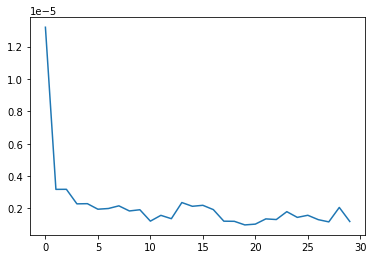

In [219]:
plt.plot(b, auto)

In [302]:
hypothesis_results = make_empty_hypothesis_results()
hypothesis_p = make_empty_hypothesis_results()
summary_names = ['MSE', 'QLIKE']
for model_name in model_names:
    for summary_name in summary_names:
        difference_averaged = summary_difference_averaged(summary_details_dict, model_name, summary_name)
        mean = np.nanmean(difference_averaged)
        variance_d = np.nanvar(difference_averaged) / len(difference_averaged)
        # variance_d = diebold_mariano_variance_estimate(difference_averaged, 1)
        variance_d = get_newey_west_error(difference_averaged, 5) ** 2
        dm_stat = normalised_stat(mean, variance_d)
        p = normal_p_value(dm_stat)
        hypothesis_results[model_name].loc[summary_name] = dm_stat
        hypothesis_p[model_name].loc[summary_name] = p
        # print(f"Done with {model_name} with {summary_name}.")

c:\users\wang-\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\wang-\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [303]:
hypothesis_results

Model,AR(1),AR(30),HAR,HAR+I
MSE,4.020825865,7.501772076,4.989002519,2.722700675
QLIKE,2.733009938,4.293141713,9.485333488,5.600149225


In [314]:
file_name = 'results/hypothesis_results.tex'

precision_digits = 3
format_type='g'
alternate = '#'
my_formatter = f"{{:{alternate}.{precision_digits}{format_type}}}".format


hypothesis_results.to_latex(
    file_name,
    escape=False, 
    float_format=my_formatter, 
    multirow=True, 
    na_rep="", 
    multicolumn_format="c",
)

In [224]:
oos_results_mean

Model        AR(1)                    AR(30)                       HAR  \
Data      Calendar      Rolling     Calendar      Rolling     Calendar   
$R^2$  0.555393165  0.562172869  0.517090336  0.597589017  0.573172815   
MSE    0.000002288  0.000002243  0.000002567  0.000002098  0.000002274   
QLIKE  0.156234390  0.155706945  0.162725042  0.141415095  0.143821868   

Model                     HAR+I               
Data       Rolling     Calendar      Rolling  
$R^2$  0.585285049  0.613970806  0.632705558  
MSE    0.000002199  0.000001954  0.000001869  
QLIKE  0.141886788  0.135665942  0.133970752

In [299]:
precision_digits = 3
format_type='g'
my_formatter = f"{{:.{precision_digits}{format_type}}}".format

In [298]:
oos_results_mean

Model        AR(1)                    AR(30)                       HAR  \
Data      Calendar      Rolling     Calendar      Rolling     Calendar   
$R^2$  0.555393165  0.562172869  0.517090336  0.597589017  0.573172815   
MSE    0.000002288  0.000002243  0.000002567  0.000002098  0.000002274   
QLIKE  0.156234390  0.155706945  0.162725042  0.141415095  0.143821868   

Model                     HAR+I               
Data       Rolling     Calendar      Rolling  
$R^2$  0.585285049  0.613970806  0.632705558  
MSE    0.000002199  0.000001954  0.000001869  
QLIKE  0.141886788  0.135665942  0.133970752

In [315]:
file_name = 'results/out_of_sample_summary.tex'

precision_digits = 3
format_type='g'
alternate = '#'
my_formatter = f"{{:{alternate}.{precision_digits}{format_type}}}".format

oos_results_mean.to_latex(
    file_name,
    escape=False, 
    float_format=my_formatter, 
    multirow=True, 
    na_rep="", 
    multicolumn_format="c",
)

In [ ]:
# code to fix nans

In [345]:
for i, symbol in enumerate(symbols_list):
    oos_results = oos_results_dict[symbol]
    for data_type in ['Calendar', 'Rolling']:
        for model_name, function in model_name_to_function.items():
            # check if QLIKE and MSE are accurate
            for summary_name in ['MSE', 'QLIKE']:
                details = summary_details_dict[symbol][(model_name, data_type, summary_name)]
                details_average = np.nanmean(details)
                recorded_value = oos_results_dict[symbol][model_name, data_type].loc[summary_name]
                try:
                    assert details_average == recorded_value
                except AssertionError:
                    oos_results_dict[symbol][model_name, data_type].loc[summary_name] = details_average

In [349]:
# now make heatmap

In [350]:
oos_results_dict['bnbbtc']

Model        AR(1)                    AR(30)                       HAR  \
Data      Calendar      Rolling     Calendar      Rolling     Calendar   
$R^2$  0.684850869  0.693576768  0.622131743  0.704514844  0.692784615   
MSE    0.000000728  0.000000707  0.000000901  0.000000705  0.000000733   
QLIKE  0.129213476  0.128466050  0.132168628  0.118811147  0.110365146   

Model                     HAR+I               
Data       Rolling     Calendar      Rolling  
$R^2$  0.706449237  0.702643035  0.721859714  
MSE    0.000000700  0.000000709  0.000000663  
QLIKE  0.108656074  0.109987856  0.107097533

In [351]:
# one for each of R^2, MSE, and QLIKE

In [353]:
df = pd.concat(oos_results_dict)

In [365]:
df.index.names = ['Symbol', 'Summary']

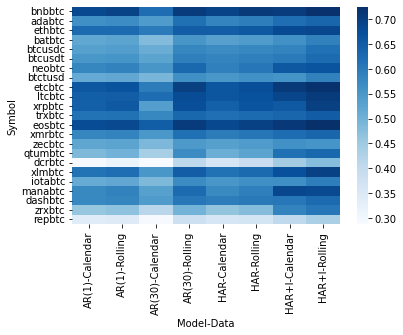

In [398]:
summary_to_plot = '$R^2$'
df_to_plot = (
    df[df.index.get_level_values(1).isin([summary_to_plot])]
    .droplevel('Summary', axis=0)
)
ax = sns.heatmap(df_to_plot, cmap="Blues", yticklabels=True)
filename = 'results/r_squared_heatmap.png'
dpi = 300
bbox_inches = 'tight'

ax.figure.savefig(
    filename,
    dpi=dpi,
    bbox_inches=bbox_inches,
    pad_inches=pad_inches
)

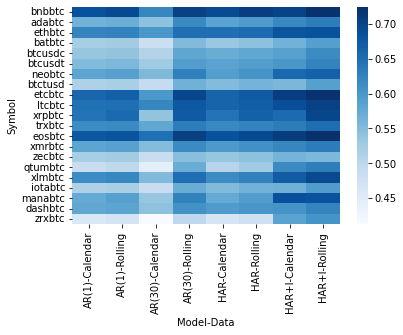

In [399]:
summary_to_plot = '$R^2$'
df_to_plot = (
    df[df.index.get_level_values(1).isin([summary_to_plot])]
    .droplevel('Summary', axis=0)
    .drop(index=['dcrbtc', 'repbtc'])
)

ax = sns.heatmap(df_to_plot, cmap="Blues", yticklabels=True)
filename = 'results/r_squared_heatmap_without_outliers.png'
dpi = 300
bbox_inches = 'tight'

ax.figure.savefig(
    filename,
    dpi=dpi,
    bbox_inches=bbox_inches,
    pad_inches=pad_inches
)

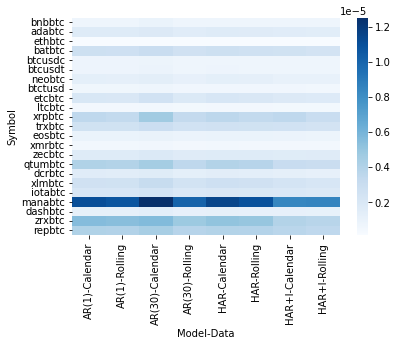

In [400]:
summary_to_plot = 'MSE'
df_to_plot = (
    df[df.index.get_level_values(1).isin([summary_to_plot])]
    .droplevel('Summary', axis=0)
)

ax = sns.heatmap(df_to_plot, cmap="Blues", yticklabels=True)
filename = 'results/mse_heatmap.png'
dpi = 300
bbox_inches = 'tight'

ax.figure.savefig(
    filename,
    dpi=dpi,
    bbox_inches=bbox_inches,
    pad_inches=pad_inches
)

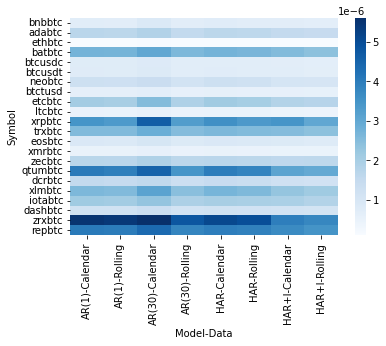

In [404]:
summary_to_plot = 'MSE'
df_to_plot = (
    df[df.index.get_level_values(1).isin([summary_to_plot])]
    .droplevel('Summary', axis=0)
    .drop(index=['manabtc'])
)

ax = sns.heatmap(df_to_plot, cmap="Blues", yticklabels=True)
filename = 'results/mse_heatmap_without_outliers.png'
dpi = 300
bbox_inches = 'tight'

ax.figure.savefig(
    filename,
    dpi=dpi,
    bbox_inches=bbox_inches,
    pad_inches=pad_inches
)

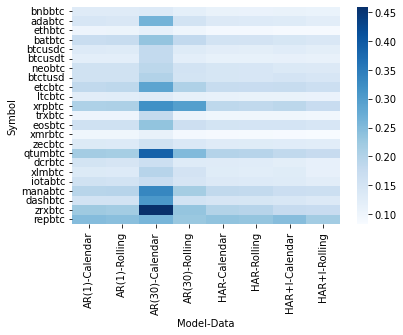

In [407]:
summary_to_plot = 'QLIKE'
df_to_plot = (
    df[df.index.get_level_values(1).isin([summary_to_plot])]
    .droplevel('Summary', axis=0)
)
ax = sns.heatmap(df_to_plot, cmap="Blues", yticklabels=True)
filename = 'results/qlike_heatmap.png'
dpi = 300
bbox_inches = 'tight'

ax.figure.savefig(
    filename,
    dpi=dpi,
    bbox_inches=bbox_inches,
    pad_inches=pad_inches
)

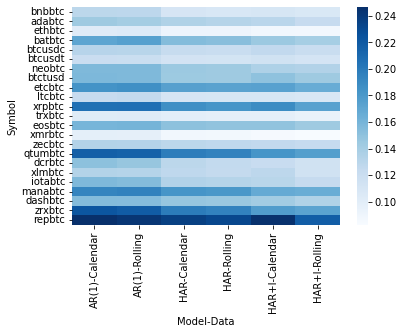

In [408]:
summary_to_plot = 'QLIKE'
df_to_plot = (
    df[df.index.get_level_values(1).isin([summary_to_plot])]
    .droplevel('Summary', axis=0)
    .drop(columns='AR(30)')
)

ax = sns.heatmap(df_to_plot, cmap="Blues", yticklabels=True)
filename = 'results/qlike_heatmap_without_outliers.png'
dpi = 300
bbox_inches = 'tight'

ax.figure.savefig(
    filename,
    dpi=dpi,
    bbox_inches=bbox_inches,
    pad_inches=pad_inches
)